Philippe Joly 2025-05-25

# Data Size Overview

This notebook explores the size of the ALBATROS data and how much can be processed within the MIST machine architecture

## MIST Machine Specifications
Information found here comes from the [MIST Docs](https://docs.scinet.utoronto.ca/index.php/Mist#Specifications)

Mist is a SciNet-SOSCIP joint GPU cluster consisting of:
- 54 IBM AC922 servers
- Each node has:
    - 32 IBM Power9 cores
    - 256 GB RAM
    - 4 NVIDIA V100-SMX2 32 GB GPUs

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## ALBATROS Data Size 

We can first look at the size of the desired output data. As information is conserved through the transforms, it will be sufficient when comparing it to GPU RAM. 

We can also look at exactly what initial data and parameters are needed to get the desired resultant data

In [3]:
with np.load("/project/s/sievers/mohanagr/xcorr_axion/xcorr_all_ant_4bit_1721361571_14336_64_15326_0_120.npz") as f:
    data = f['data']
    mask = f['mask']
    missing_fraction = f["missing_fraction"]
    chans = f['chans']

In [4]:
print("Data Shape:", data.shape)
print("Mask Shape:", mask.shape)
print("Missing Fraction Shape:", missing_fraction.shape)
print("Channels Shape", chans.shape)

Data Shape: (2, 2, 7680, 15326)
Mask Shape: (2, 2, 7680, 15326)
Missing Fraction Shape: (1, 15326)
Channels Shape (7680,)


In [5]:
print("Data Size:", data.nbytes*1e-9, "GB") # (4 bits * 2 [complex]) * 4 [polarisations] * (120*64) [frequency] * 15326 [time] 
print("Mask Size:", mask.nbytes*1e-6, "MB")
print("Missing Fraction Size:", missing_fraction.nbytes*1e-3, "kB")
print("Channels Size", chans.nbytes*1e-3, "kB\n")

print("Predicted File Size", (data.nbytes+mask.nbytes+missing_fraction.nbytes+chans.nbytes)*1e-9, "GB")
print("File Size (checked on NIAGARA) 4.237517668 GB")

Data Size: 3.76651776 GB
Mask Size: 470.81471999999997 MB
Missing Fraction Size: 122.608 kB
Channels Size 61.44 kB

Predicted File Size 4.2375165280000004 GB
File Size (checked on NIAGARA) 4.237517668 GB


In [6]:
df_record = 125e6/2048

def get_size(band, resolution, time, avg_ws=14336):
    return 8*4*band/resolution*(time*df_record/avg_ws) # Bytes

def get_max_len(band, resolution, size, avg_ws=14336):
    return size*resolution*avg_ws/(8*4*df_record*band) # (Hz)

def get_max_band(time, resolution, size, avg_ws=14336):
    return size*resolution*avg_ws/(8*4*df_record*time) # (sec)

## CPU RAM Limitations

From Signal expectations (See notebook), we want to be able to observe bands of 5-30 Hz. So we want ~1 Hz resolution. Note that we can only rechannelize by powers of 2.

In [7]:
new_df = df_record/ 2**16

print("Recorded Frequency Resolution:", df_record*1e-3, "kHz")
print("Desired Frequency Resolution:", new_df, "Hz")

Recorded Frequency Resolution: 61.03515625 kHz
Desired Frequency Resolution: 0.9313225746154785 Hz


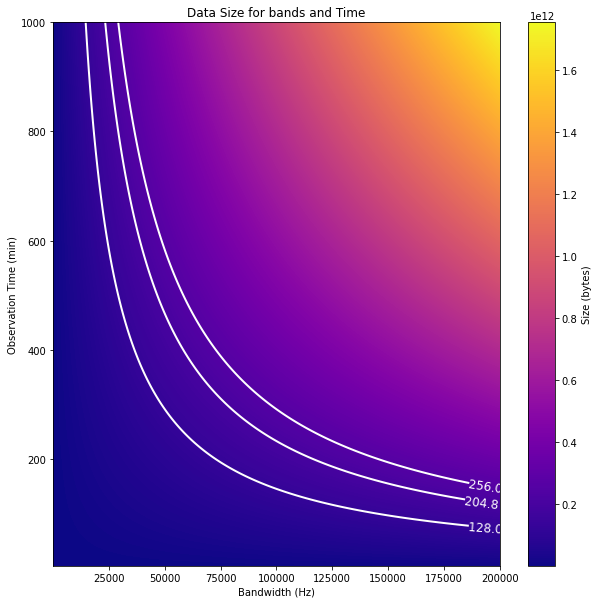

In [13]:
band = np.linspace(100, 2e5, int(1e4)) # (Hz)
time = np.linspace(5, 1000, 1000)*60 # (sec)

f, t = np.meshgrid(band, time)
size = get_size(f, new_df, t)

plt.figure(figsize=(10,10))

im = plt.imshow(size, extent=[100, 2e5, 5, 1000], origin='lower', cmap='plasma', aspect='auto')

CPU_RAM = 256e9
N = np.array([0.5,0.8, 1])*CPU_RAM 
for i in range(N.shape[0]):
    contour = plt.contour(band, time/60, size, levels=[N[i]], colors='White', linewidths=2)
    plt.clabel(contour, inline=True, fontsize=12, fmt=f'{N[i]/1e9} GB')

plt.ylabel("Observation Time (min)")
plt.xlabel("Bandwidth (Hz)")
plt.title("Data Size for bands and Time")
plt.colorbar(im, label='Size (bytes)')  
plt.show()

In [16]:
k=np.array([1,2])
2/k

array([2., 1.])

## GPU Limitations 

The number of frequency channels nor the observation time affects the GPU RAM requirements. Those 2 factors only affect processing time (lineary). 

The GPU requirements follow from the oversampling rate $\sigma$ and the PFB size multplier $N_{avg}$.
$$S = 2\times2048 \times 4\times \sigma\times N_{avg}$$

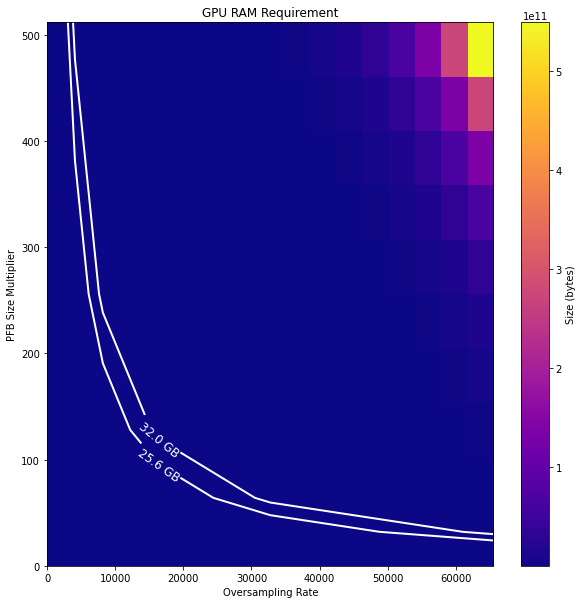

In [28]:
def get_gpu_size(osamp, pfb_size_mult):
    return 8*2048*osamp*pfb_size_mult

def get_max_osamp(pfb, size):
    return size/(8*2048*pfb)

def get_max_pfb(osamp, size):
    return size/(8*2048*osamp)

osamp = []
# pfb_sz = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])

pfb_sz = []
for i in range(10):
    pfb_sz.append(2**i)
pfb_sz = np.array(pfb_sz)
    
for i in range(17):
    osamp.append(2**i)
osamp = np.array(osamp)
freqs = df_record/osamp

o, p = np.meshgrid(osamp, pfb_sz)
gpu_size = get_gpu_size(o, p)

plt.figure(figsize=(10,10))

im = plt.imshow(gpu_size, extent=[0, 2**16, 0, 2**9], origin='lower', cmap='plasma', aspect='auto')

GPU_RAM = 32e9
N = np.array([0.8, 1])*GPU_RAM 
for i in range(N.shape[0]):
    contour = plt.contour(osamp, pfb_sz, gpu_size, levels=[N[i]], colors='White', linewidths=2)
    plt.clabel(contour, inline=True, fontsize=12, fmt=f'{N[i]/1e9} GB')

plt.ylabel("PFB Size Multiplier")
plt.xlabel("Oversampling Rate")
plt.title("GPU RAM Requirement")
plt.colorbar(im, label='Size (bytes)')  
plt.show()

In [29]:
get_max_pfb(2**16, 32e9)

29.802322387695312